# Assignment 2
MIE1642 Intro. to Data Science <br> 
By: Rahul Rohatgi <br>
Date: Dec 11,2017 <br>

## 1.0 Importing Libraries

The following are the libraries used to accomplish the analysis.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.cross_validation import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.grid_search import GridSearchCV



/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## 2.0 Data Cleaning

First the income data is imported using pandas. Then the length of the data is checked which will be used later to compare with.
<br><br>
_Note that for the file to be read it must be present within the workbench with the exact same name._

In [2]:
dataset = pd.read_csv('income-training.csv')
#dataset.head()

In [3]:
len(dataset)

24421

### 2.1 Dealing With Missing Values

The missing values are removed from the dataset. However, there are special cases for Occupation, WorkClass, MaritalStatus, Relationship, Education, and EducationLvl. As seen in the code below if both combination are missing together the data sample is  dropped but if just one is missing then it is not. This is because one category can help determine the missing value of the other. For example, if MartialStatus says married-civ-spouse then they can be either husband or wife and the mode value can be used here. These are the special cases, but for the other columns if they are blank there is no way to identify the results therefore they are dropped.  

In [4]:
dataset = dataset.dropna(subset=["Occupation","WorkClass"],thresh=1)
dataset = dataset.dropna(subset=["MaritalStatus","Relationship"],thresh=1)
dataset = dataset.dropna(subset=["Education","EducationLvl"],thresh=1)
dataset = dataset.dropna(subset=["Age"])
dataset = dataset.dropna(subset=["FinalWeight"])
dataset = dataset.dropna(subset=["Race"])
dataset = dataset.dropna(subset=["Sex"])
dataset = dataset.dropna(subset=["CapitalGain"])
dataset = dataset.dropna(subset=["CapitalLoss"])
dataset = dataset.dropna(subset=["HoursPerWeek"])
dataset = dataset.dropna(subset=["NativeCountry"])
dataset = dataset.dropna(subset=["IncomeBracket"])

The reason there are missing values is because the information may not have been given by the person or they do not fall into the options available for the category. Note that reasons for not giving information can vary.<br><br> Deleting the sample might affect the overall analysis negatively if too many samples are dropped but since the dataset is so large this is not a huge issue. As well, guessing for categories value may result in outliers that can affect the models being used. For example, if the FinalWeight is missing and that is taken as the mean well that may be completely off. This column is based upon demographic background which has multiple conditions and taking the average will give a false story. It is like the example of the average water being 3ft deep but there is large dip of 10ft in the middle.  The same can be said for all the other columns. Thus, it is better to remove the sample than to 'guess' without knowledge when the dataset is so large. 

_Note below even the special cases are dropped as well._ 

In [5]:
dataset = dataset.dropna(subset=["Occupation"])
dataset = dataset.dropna(subset=["WorkClass"])
dataset = dataset.dropna(subset=["MaritalStatus"])
dataset = dataset.dropna(subset=["Relationship"])
dataset = dataset.dropna(subset=["Education"])
dataset = dataset.dropna(subset=["EducationLvl"])

In [6]:
len(dataset)

22654

Above result is just the number of samples left after dropping stage is found. This is compared with the first length found. Since there is a lot of data samples still left, dropping the samples in the above phase is justifiable.

### 2.2 Encoding the Dataset

In order to encode the data type of each column is required. Then it is possible to determine what type of encoding should be done.

In [7]:
dataset.dtypes

Age               int64
WorkClass        object
FinalWeight       int64
Education        object
EducationLvl      int64
MaritalStatus    object
Occupation       object
Relationship     object
Race             object
Sex              object
CapitalGain       int64
CapitalLoss       int64
HoursPerWeek      int64
NativeCountry    object
IncomeBracket    object
dtype: object

Below is the code for encoding the objects. All the columns in the code below are changed to categories and encoded to give a value for each type of option within the column. <br> I.e. WorkClass Options: <br> Private = 0 <br> Local-gov = 1 <br> State-gov = 2 <br> etc. <br> Note the following exact numbers are not used. <br><br> This particular method was used because there are more than two options for most so True/False and 0/1 can not be used. Also for machine learning everything has to be represented in numbers. 

In [8]:
dataset["WorkClass"] = dataset["WorkClass"].astype('category')
dataset["WorkClassLvl"] = dataset["WorkClass"].astype('category').cat.codes
dataset["MaritalStatus"] = dataset["MaritalStatus"].astype('category')
dataset["MaritalStatusLvl"] = dataset["MaritalStatus"].astype('category').cat.codes
dataset["Occupation"] = dataset["Occupation"].astype('category')
dataset["OccupationLvl"] = dataset["Occupation"].astype('category').cat.codes
dataset["Relationship"] = dataset["Relationship"].astype('category')
dataset["RelationshipLvl"] = dataset["Relationship"].astype('category').cat.codes
dataset["Race"] = dataset["Race"].astype('category')
dataset["RaceLvl"] = dataset["Race"].astype('category').cat.codes
dataset["Sex"] = dataset["Sex"].astype('category')
dataset["SexLvl"] = dataset["Sex"].astype('category').cat.codes
dataset["NativeCountry"] = dataset["NativeCountry"].astype('category')
dataset["NativeCountryLvl"] = dataset["NativeCountry"].astype('category').cat.codes
dataset["IncomeBracketLvl"] = dataset["IncomeBracket"].astype('category').cat.codes #Note that 50-100k = 0, <50k = 1, >100k = 2

To clean up the dataset Age and HoursPerWeek which are continuous types are put into groups. This was done to reduce the number of points for the machine learning part and for analysis of the data to be easier. <br><br> For the Age groups the first set is taken to account for post secondary education and the last group is post retirement. Similarly, the HoursPerWeek group were taken for 20 hours interval. Note that these groups were created with the aid of the information of the max, and min values.

In [9]:
dataset['AgeLvl'] = pd.cut(dataset['Age'], bins=[17,23,29,39,49,64,np.inf], labels=[0,1,2,3,4,5])
dataset['HoursPerWeekLvl'] = pd.cut(dataset['HoursPerWeek'], bins=[0,20,40,60,80,np.inf], labels=[0,1,2,3,4])

This concludes the main data cleaning stage for the dataset. Note more data cleaning is done later in the analysis for tasks such as feature selection. 

## 3.0 Exploratory Data Analysis

### 3.1 Part A Graphs

####  3.1.1 Graph 1: Age Groups vs Income Bracket

To create the graph the following procedure was used. First only one income bracket level is extracted from the dataset. Next each age group is extracted from that new dataset. Then the number of samples for each is found which, is used to create the bar graph. 

In [10]:
Age50 = dataset[dataset.IncomeBracket == '<50K']
Age50_17_23 = Age50[Age50.AgeLvl == 0]
Age50_24_29 = Age50[Age50.AgeLvl == 1]
Age50_30_39 = Age50[Age50.AgeLvl == 2]
Age50_40_49 = Age50[Age50.AgeLvl == 3]
Age50_50_64 = Age50[Age50.AgeLvl == 4]
Age50_65 = Age50[Age50.AgeLvl == 5]
Age50_17_23_l = len(Age50_17_23)
Age50_24_29_l = len(Age50_24_29)
Age50_30_39_l = len(Age50_30_39)
Age50_40_49_l = len(Age50_40_49)
Age50_50_64_l = len(Age50_50_64)
Age50_65_l = len(Age50_65)

In [11]:
Age50_100 = dataset[dataset.IncomeBracket == '50-100K']
Age50_100_17_23 = Age50_100[Age50_100.AgeLvl == 0]
Age50_100_24_29 = Age50_100[Age50_100.AgeLvl == 1]
Age50_100_30_39 = Age50_100[Age50_100.AgeLvl == 2]
Age50_100_40_49 = Age50_100[Age50_100.AgeLvl == 3]
Age50_100_50_64 = Age50_100[Age50_100.AgeLvl == 4]
Age50_100_65 = Age50_100[Age50_100.AgeLvl == 5]
Age50_100_17_23_l = len(Age50_100_17_23)
Age50_100_24_29_l = len(Age50_100_24_29)
Age50_100_30_39_l = len(Age50_100_30_39)
Age50_100_40_49_l = len(Age50_100_40_49)
Age50_100_50_64_l = len(Age50_100_50_64)
Age50_100_65_l = len(Age50_100_65)

In [12]:
Age100 = dataset[dataset.IncomeBracket == '>100K']
Age100_17_23 = Age100[Age100.AgeLvl == 0]
Age100_24_29 = Age100[Age100.AgeLvl == 1]
Age100_30_39 = Age100[Age100.AgeLvl == 2]
Age100_40_49 = Age100[Age100.AgeLvl == 3]
Age100_50_64 = Age100[Age100.AgeLvl == 4]
Age100_65 = Age100[Age100.AgeLvl == 5]
Age100_17_23_l = len(Age100_17_23)
Age100_24_29_l = len(Age100_24_29)
Age100_30_39_l = len(Age100_30_39)
Age100_40_49_l = len(Age100_40_49)
Age100_50_64_l = len(Age100_50_64)
Age100_65_l = len(Age100_65)

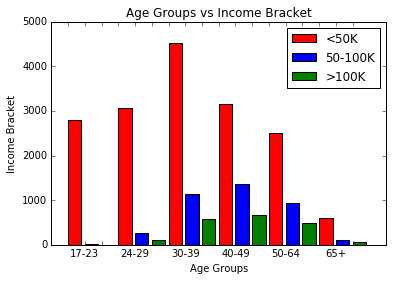

In [13]:
x = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
x2 = ['','17-23','','','24-29','','','30-39',' ','','40-49','','','50-64','','','65+''',]

plt.bar(x[0],Age50_17_23_l,label='<50K',color='red')
plt.bar(x[1],Age50_100_17_23_l,label='50-100K',color='blue')
plt.bar(x[2],Age100_17_23_l,label='>100K',color='green')
plt.bar(x[3],Age50_24_29_l,color='red')
plt.bar(x[4],Age50_100_24_29_l,color='blue')
plt.bar(x[5],Age100_24_29_l,color='green')
plt.bar(x[6],Age50_30_39_l,color='red')
plt.bar(x[7],Age50_100_30_39_l,color='blue')
plt.bar(x[8],Age100_30_39_l,color='green')
plt.bar(x[9],Age50_40_49_l,color='red')
plt.bar(x[10],Age50_100_40_49_l,color='blue')
plt.bar(x[11],Age100_40_49_l,color='green')
plt.bar(x[12],Age50_50_64_l,color='red')
plt.bar(x[13],Age50_100_50_64_l,color='blue')
plt.bar(x[14],Age100_50_64_l,color='green')
plt.bar(x[15],Age50_65_l,color='red')
plt.bar(x[16],Age50_100_65_l,color='blue')
plt.bar(x[17],Age100_65_l,color='green')
plt.xticks(x,x2)
plt.xlabel('Age Groups')
plt.ylabel('Income Bracket')
plt.title('Age Groups vs Income Bracket')
plt.legend()

The trend from this figure shows that most of the income brackets are less than 50k. This means that most likely the classifier will predict a income bracket of less than 50k. As well, the figure shows that middle age people are the ones that have a higher change of being in another bracket. This information can be helpful in classifying other samples. For example, if the new sample is of age 35 then the algorithm knows that the probability that the person makes less than 50k is not the same as someone who is 21. With this information it can be concluded that Age can be a useful feature.  

#### 3.1.2 Graph 2: Hours Per Week vs Income Bracket

To create the graph the following procedure was used. First only one income bracket level is extracted from the dataset. Next each hours-per-week group is extracted from that new dataset. Then the number of samples for each is found which, is used to create the bar graph. 

In [14]:
HoursPerWeek50 = dataset[dataset.IncomeBracket == '<50K']
HoursPerWeek50_0_20 = HoursPerWeek50[HoursPerWeek50.HoursPerWeekLvl == 0]
HoursPerWeek50_21_40 = HoursPerWeek50[HoursPerWeek50.HoursPerWeekLvl == 1]
HoursPerWeek50_41_60 = HoursPerWeek50[HoursPerWeek50.HoursPerWeekLvl == 2]
HoursPerWeek50_61_80 = HoursPerWeek50[HoursPerWeek50.HoursPerWeekLvl == 3]
HoursPerWeek50_80 = HoursPerWeek50[HoursPerWeek50.HoursPerWeekLvl == 4]
HoursPerWeek50_0_20_l = len(HoursPerWeek50_0_20)
HoursPerWeek50_21_40_l = len(HoursPerWeek50_21_40 )
HoursPerWeek50_41_60_l = len(HoursPerWeek50_41_60)
HoursPerWeek50_61_80_l = len(HoursPerWeek50_61_80)
HoursPerWeek50_80_l = len(HoursPerWeek50_80)

In [15]:
HoursPerWeek50_100 = dataset[dataset.IncomeBracket == '50-100K']
HoursPerWeek50_100_0_20 = HoursPerWeek50_100[HoursPerWeek50_100.HoursPerWeekLvl == 0]
HoursPerWeek50_100_21_40 = HoursPerWeek50_100[HoursPerWeek50_100.HoursPerWeekLvl == 1]
HoursPerWeek50_100_41_60 = HoursPerWeek50_100[HoursPerWeek50_100.HoursPerWeekLvl == 2]
HoursPerWeek50_100_61_80 = HoursPerWeek50_100[HoursPerWeek50_100.HoursPerWeekLvl == 3]
HoursPerWeek50_100_80 = HoursPerWeek50_100[HoursPerWeek50_100.HoursPerWeekLvl == 4]
HoursPerWeek50_100_0_20_l = len(HoursPerWeek50_100_0_20)
HoursPerWeek50_100_21_40_l = len(HoursPerWeek50_100_21_40 )
HoursPerWeek50_100_41_60_l = len(HoursPerWeek50_100_41_60)
HoursPerWeek50_100_61_80_l = len(HoursPerWeek50_100_61_80)
HoursPerWeek50_100_80_l = len(HoursPerWeek50_100_80)

In [16]:
HoursPerWeek100 = dataset[dataset.IncomeBracket == '>100K']
HoursPerWeek100_0_20 = HoursPerWeek100[HoursPerWeek100.HoursPerWeekLvl == 0]
HoursPerWeek100_21_40 = HoursPerWeek100[HoursPerWeek100.HoursPerWeekLvl == 1]
HoursPerWeek100_41_60 = HoursPerWeek100[HoursPerWeek100.HoursPerWeekLvl == 2]
HoursPerWeek100_61_80 = HoursPerWeek100[HoursPerWeek100.HoursPerWeekLvl == 3]
HoursPerWeek100_80 = HoursPerWeek100[HoursPerWeek100.HoursPerWeekLvl == 4]
HoursPerWeek100_0_20_l = len(HoursPerWeek100_0_20)
HoursPerWeek100_21_40_l = len(HoursPerWeek100_21_40 )
HoursPerWeek100_41_60_l = len(HoursPerWeek100_41_60)
HoursPerWeek100_61_80_l = len(HoursPerWeek100_61_80)
HoursPerWeek100_80_l = len(HoursPerWeek100_80)

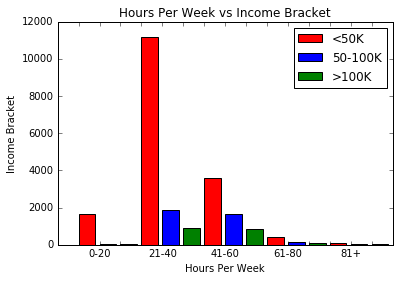

In [17]:
x = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
x2 = ['','0-20','','','21-40','','','41-60',' ','','61-80','','','81+']

plt.bar(x[0],HoursPerWeek50_0_20_l,label='<50K',color='red')
plt.bar(x[1],HoursPerWeek50_100_0_20_l,label='50-100K',color='blue')
plt.bar(x[2],HoursPerWeek100_0_20_l,label='>100K',color='green')
plt.bar(x[3],HoursPerWeek50_21_40_l,color='red')
plt.bar(x[4],HoursPerWeek50_100_21_40_l,color='blue')
plt.bar(x[5],HoursPerWeek100_21_40_l,color='green')
plt.bar(x[6],HoursPerWeek50_41_60_l,color='red')
plt.bar(x[7],HoursPerWeek50_100_41_60_l,color='blue')
plt.bar(x[8],HoursPerWeek100_41_60_l,color='green')
plt.bar(x[9],HoursPerWeek50_61_80_l,color='red')
plt.bar(x[10],HoursPerWeek50_100_61_80_l,color='blue')
plt.bar(x[11],HoursPerWeek100_61_80_l,color='green')
plt.bar(x[12],HoursPerWeek50_80_l,color='red')
plt.bar(x[13],HoursPerWeek50_100_80_l,color='blue')
plt.bar(x[14],HoursPerWeek100_80_l,color='green')
plt.xticks(x,x2)
plt.xlabel('Hours Per Week')
plt.ylabel('Income Bracket')
plt.title('Hours Per Week vs Income Bracket')
plt.legend()

The figure above shows that majority of the people work between 21-60 hours and the majority of the people working between 21-40 hours get paid below 50k. It also shows that increased hour from this time does not affect the number of people making more than 50k. This trend would help classify samples with lows hours per week because it shows that there is a great chance that the person will fall within the less than 50k if they do not work as many hours. 

#### 3.1.3 Graph 3: Final Weight vs Income Bracket

To create the graph the following procedure was used. First the FinalWeight is grouped together in the same fashion as Age and HoursPerWeek. The groupings are taken based on the min and max value found of the data and then some trail and error. Secondly to create the graph only one income bracket level is extracted from the dataset. Next each final-weight group is extracted from that new dataset. Then the number of samples for each is found which is used to create the bar graph. 

In [18]:
dataset['FinalWeightLvl'] = pd.cut(dataset['FinalWeight'], 
                                   bins=[0,150000,300000,450000,600000,1000000,np.inf], labels=[0,1,2,3,4,5])

In [19]:
FinalWeight50 = dataset[dataset.IncomeBracket == '<50K']
FinalWeight50_1 = FinalWeight50[FinalWeight50.FinalWeightLvl == 0]
FinalWeight50_2 = FinalWeight50[FinalWeight50.FinalWeightLvl == 1]
FinalWeight50_3 = FinalWeight50[FinalWeight50.FinalWeightLvl == 2]
FinalWeight50_4 = FinalWeight50[FinalWeight50.FinalWeightLvl == 3]
FinalWeight50_5 = FinalWeight50[FinalWeight50.FinalWeightLvl == 4]
FinalWeight50_6 = FinalWeight50[FinalWeight50.FinalWeightLvl == 5]
FinalWeight50_1_l = len(FinalWeight50_1)
FinalWeight50_2_l = len(FinalWeight50_2)
FinalWeight50_3_l = len(FinalWeight50_3)
FinalWeight50_4_l = len(FinalWeight50_4)
FinalWeight50_5_l = len(FinalWeight50_5)
FinalWeight50_6_l = len(FinalWeight50_6)

In [20]:
FinalWeight50_100 = dataset[dataset.IncomeBracket == '50-100K']
FinalWeight50_100_1 = FinalWeight50_100[FinalWeight50_100.FinalWeightLvl == 0]
FinalWeight50_100_2 = FinalWeight50_100[FinalWeight50_100.FinalWeightLvl == 1]
FinalWeight50_100_3 = FinalWeight50_100[FinalWeight50_100.FinalWeightLvl == 2]
FinalWeight50_100_4 = FinalWeight50_100[FinalWeight50_100.FinalWeightLvl == 3]
FinalWeight50_100_5 = FinalWeight50_100[FinalWeight50_100.FinalWeightLvl == 4]
FinalWeight50_100_6 = FinalWeight50_100[FinalWeight50_100.FinalWeightLvl == 5]
FinalWeight50_100_1_l = len(FinalWeight50_100_1)
FinalWeight50_100_2_l = len(FinalWeight50_100_2)
FinalWeight50_100_3_l = len(FinalWeight50_100_3)
FinalWeight50_100_4_l = len(FinalWeight50_100_4)
FinalWeight50_100_5_l = len(FinalWeight50_100_5)
FinalWeight50_100_6_l = len(FinalWeight50_100_6)

In [21]:
FinalWeight100 = dataset[dataset.IncomeBracket == '>100K']
FinalWeight100_1 = FinalWeight100[FinalWeight100.FinalWeightLvl == 0]
FinalWeight100_2 = FinalWeight100[FinalWeight100.FinalWeightLvl == 1]
FinalWeight100_3 = FinalWeight100[FinalWeight100.FinalWeightLvl == 2]
FinalWeight100_4 = FinalWeight100[FinalWeight100.FinalWeightLvl == 3]
FinalWeight100_5 = FinalWeight100[FinalWeight100.FinalWeightLvl == 4]
FinalWeight100_6 = FinalWeight100[FinalWeight100.FinalWeightLvl == 5]
FinalWeight100_1_l = len(FinalWeight100_1)
FinalWeight100_2_l = len(FinalWeight100_2)
FinalWeight100_3_l = len(FinalWeight100_3)
FinalWeight100_4_l = len(FinalWeight100_4)
FinalWeight100_5_l = len(FinalWeight100_5)
FinalWeight100_6_l = len(FinalWeight100_6)

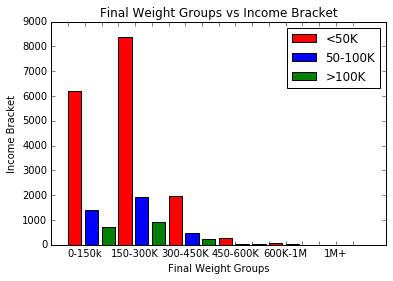

In [22]:
x = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
x2 = ['','0-150k','','','150-300K','','','300-450K','','','450-600K','','','600K-1M','','','1M+''',]

plt.bar(x[0],FinalWeight50_1_l,label='<50K',color='red')
plt.bar(x[1],FinalWeight50_100_1_l,label='50-100K',color='blue')
plt.bar(x[2],FinalWeight100_1_l,label='>100K',color='green')
plt.bar(x[3],FinalWeight50_2_l,color='red')
plt.bar(x[4],FinalWeight50_100_2_l,color='blue')
plt.bar(x[5],FinalWeight100_2_l,color='green')
plt.bar(x[6],FinalWeight50_3_l,color='red')
plt.bar(x[7],FinalWeight50_100_3_l,color='blue')
plt.bar(x[8],FinalWeight100_3_l,color='green')
plt.bar(x[9],FinalWeight50_4_l,color='red')
plt.bar(x[10],FinalWeight50_100_4_l,color='blue')
plt.bar(x[11],FinalWeight100_4_l,color='green')
plt.bar(x[12],FinalWeight50_5_l,color='red')
plt.bar(x[13],FinalWeight50_100_5_l,color='blue')
plt.bar(x[14],FinalWeight100_5_l,color='green')
plt.bar(x[15],FinalWeight50_6_l,color='red')
plt.bar(x[16],FinalWeight50_100_6_l,color='blue')
plt.bar(x[17],FinalWeight100_6_l,color='green')
plt.xticks(x,x2)
plt.xlabel('Final Weight Groups')
plt.ylabel('Income Bracket')
plt.title('Final Weight Groups vs Income Bracket')
plt.legend()

The figure displays that most of the samples have a similar demographics. The ratio/probability for each of the three demographics between the three income brackets is very similar. This means that the demographics do not really affect the chances of the income bracket being different for a certain group. For example, for all three major groups it is equal chance to be in the less than 50k even if the sample FinalWeight value changed. Therefore, the trend shown here would not really aid in classification that well unless the FinalWeight value was greater than 450k. 

### 3.2 Part B Feature Importance

#### 3.2.1 PCA (Unfiltered)

The PCA was created first by insuring all columns to be used were in integer type and then the dataset to be used would only contain number values (i.e. the 'Lvl' columns). 

In [23]:
dataset.dtypes

Age                    int64
WorkClass           category
FinalWeight            int64
Education             object
EducationLvl           int64
MaritalStatus       category
Occupation          category
Relationship        category
Race                category
Sex                 category
CapitalGain            int64
CapitalLoss            int64
HoursPerWeek           int64
NativeCountry       category
IncomeBracket         object
WorkClassLvl            int8
MaritalStatusLvl        int8
OccupationLvl           int8
RelationshipLvl         int8
RaceLvl                 int8
SexLvl                  int8
NativeCountryLvl        int8
IncomeBracketLvl        int8
AgeLvl              category
HoursPerWeekLvl     category
FinalWeightLvl      category
dtype: object

In [24]:
dataset["AgeLvl"] = dataset["AgeLvl"].astype('int8')
dataset["HoursPerWeekLvl"] = dataset["HoursPerWeekLvl"].astype('int8')
dataset["FinalWeightLvl"] = dataset["FinalWeightLvl"].astype('int8')
dataset['CapitalGainLvl'] = pd.cut(dataset['CapitalGain'], 
                                   bins=[0,10000,20000,30000,40000,50000,60000,70000,80000,90000,100000,np.inf],
                                    labels=[0,1,2,3,4,5,6,7,8,9,10])
dataset["CapitalGainLvl"] = dataset["CapitalGainLvl"].astype('int8')
dataset['CapitalLossLvl'] = pd.cut(dataset['CapitalLoss'], 
                                   bins=[-np.inf,-100000,-90000,-80000,-70000,-60000,-50000,-40000,-30000,-20000,-10000,0],
                                    labels=[0,1,2,3,4,5,6,7,8,9,10])
dataset["CapitalLossLvl"] = dataset["CapitalLossLvl"].astype('int8')

In [25]:
dataset.dtypes

Age                    int64
WorkClass           category
FinalWeight            int64
Education             object
EducationLvl           int64
MaritalStatus       category
Occupation          category
Relationship        category
Race                category
Sex                 category
CapitalGain            int64
CapitalLoss            int64
HoursPerWeek           int64
NativeCountry       category
IncomeBracket         object
WorkClassLvl            int8
MaritalStatusLvl        int8
OccupationLvl           int8
RelationshipLvl         int8
RaceLvl                 int8
SexLvl                  int8
NativeCountryLvl        int8
IncomeBracketLvl        int8
AgeLvl                  int8
HoursPerWeekLvl         int8
FinalWeightLvl          int8
CapitalGainLvl          int8
CapitalLossLvl          int8
dtype: object

In [26]:
dataset_pca = dataset[['AgeLvl','WorkClassLvl','FinalWeightLvl','EducationLvl','MaritalStatusLvl','OccupationLvl',
                       'RelationshipLvl','RaceLvl','SexLvl','CapitalGainLvl','CapitalLossLvl','HoursPerWeekLvl',
                       'NativeCountryLvl','IncomeBracketLvl']]

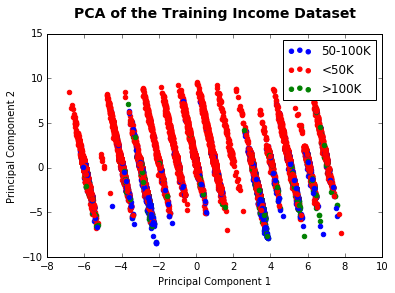

In [27]:
# Splitting data frame to x and y components.
train_x = np.array(dataset_pca[dataset_pca.columns[0:12]])
train_y = np.array(dataset_pca[dataset_pca.columns[13]])

# Initializing and fitting the PCA.
PCA_ = PCA(n_components = 2)
PCA_x = PCA_.fit(train_x).transform(train_x)

# Plotting the PCA results.
plt.figure()

for i in range(0, len(train_y)):
    if(train_y[i] == 0):
        PCA_0 = plt.scatter(PCA_x[i, 0], PCA_x[i, 1], color = 'b')
    if(train_y[i] == 1):
        PCA_1 = plt.scatter(PCA_x[i, 0], PCA_x[i, 1], color = 'r')
    if(train_y[i] == 2):
        PCA_2 = plt.scatter(PCA_x[i, 0], PCA_x[i, 1], color = 'g')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of the Training Income Dataset', fontsize = 14, fontweight = 'bold', y = 1.05)
plt.legend((PCA_0, PCA_1,PCA_2), ('50-100K', '<50K','>100K'))

The PCA above is very clustered due to the large number of samples and features. Therefore, it is difficult to conclude anything. However, there is clustering happening which is good because it shows that these features are closely related. 

#### 3.2.2 PCA Filtered

The PCA can show more information if even number of income brackets are taken. This is done here by first finding which income bracket has the least number of samples and using that number for each of the other brackets. 

In [28]:
u = dataset_pca[dataset_pca.IncomeBracketLvl == 0]
i = dataset_pca[dataset_pca.IncomeBracketLvl == 1]
k = dataset_pca[dataset_pca.IncomeBracketLvl == 2]

In [29]:
ham = len(k)
ham2 = len(i)
ham3 = len(u)
print(ham) 
print(ham2) 
print(ham3) 

1916
16901
3837


In [30]:
u2 = u.head(ham)
i2 = i.head(ham)
k2 = k.head(ham)
df=i2.append(u2)
df=df.append(k2)
df.head()

,AgeLvl,WorkClassLvl,FinalWeightLvl,EducationLvl,MaritalStatusLvl,OccupationLvl,RelationshipLvl,RaceLvl,SexLvl,CapitalGainLvl,CapitalLossLvl,HoursPerWeekLvl,NativeCountryLvl,IncomeBracketLvl
0,3,5,1,10,2,4,0,4,1,0,10,1,38,1
1,1,2,0,10,4,7,1,4,0,0,10,1,38,1
3,2,4,1,5,2,2,0,4,1,0,10,1,38,1
4,4,4,0,14,2,11,0,4,1,0,10,2,38,1
5,2,2,1,9,0,13,1,4,1,0,0,2,38,1


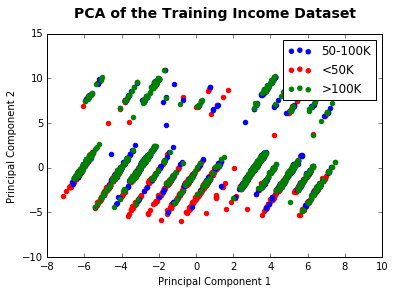

In [31]:
# Splitting data frame to x and y components.
train_x = np.array(df[df.columns[0:12]])
train_y = np.array(df[df.columns[13]])

# Initializing and fitting the PCA.
PCA_ = PCA(n_components = 2)
PCA_x = PCA_.fit(train_x).transform(train_x)

# Plotting the PCA results.
plt.figure()

for i in range(0, len(train_y)):
    if(train_y[i] == 0):
        PCA_0 = plt.scatter(PCA_x[i, 0], PCA_x[i, 1], color = 'b')
    if(train_y[i] == 1):
        PCA_1 = plt.scatter(PCA_x[i, 0], PCA_x[i, 1], color = 'r')
    if(train_y[i] == 2):
        PCA_2 = plt.scatter(PCA_x[i, 0], PCA_x[i, 1], color = 'g')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of the Training Income Dataset', fontsize = 14, fontweight = 'bold', y = 1.05)
plt.legend((PCA_0, PCA_1,PCA_2), ('50-100K', '<50K','>100K'))

This PCA is a lot clearer but still a little difficult to tell. From this PCA there is a lot of clustering of the over 100k bracket from initial inspection. The data is still sort of clustered but spread a part. This is good as the features are correlated to each other in a strong manner but not so dominant. There is somewhat of a balance which is required. However, this PCA still does not show the complete picture. 

#### 3.2.3 Correlation Plot

The complete picture can be shown using the correlation plot. 

In [32]:
eggs = dataset_pca.corr()
eggs

,AgeLvl,WorkClassLvl,FinalWeightLvl,EducationLvl,MaritalStatusLvl,OccupationLvl,RelationshipLvl,RaceLvl,SexLvl,CapitalGainLvl,CapitalLossLvl,HoursPerWeekLvl,NativeCountryLvl,IncomeBracketLvl
AgeLvl,1.000000,0.079299,-0.078425,0.071861,-0.312419,0.006031,-0.260252,0.020518,0.093649,0.065360,-0.064188,0.131475,-0.009896,-0.069749
WorkClassLvl,0.079299,1.000000,-0.040670,0.040821,-0.030062,0.007079,-0.067652,0.049870,0.068650,0.036093,-0.005483,0.063912,0.004753,0.001018
FinalWeightLvl,-0.078425,-0.040670,1.000000,-0.033791,0.034121,-0.003155,0.016501,-0.019036,0.026419,-0.000505,-0.000443,-0.020335,-0.058004,-0.003030
EducationLvl,0.071861,0.040821,-0.033791,1.000000,-0.067857,0.092289,-0.095124,0.023590,0.009803,0.117617,-0.076479,0.160782,0.092391,-0.103627
MaritalStatusLvl,-0.312419,-0.030062,0.034121,-0.067857,1.000000,0.010269,0.179989,-0.063804,-0.121328,-0.031451,0.036773,-0.166102,-0.023400,0.059382
OccupationLvl,0.006031,0.007079,-0.003155,0.092289,0.010269,1.000000,-0.055580,0.008640,0.063166,0.022607,-0.014920,0.050055,-0.002141,-0.015477
RelationshipLvl,-0.260252,-0.067652,0.016501,-0.095124,0.179989,-0.055580,1.000000,-0.123722,-0.588315,-0.042249,0.054011,-0.244810,-0.008403,0.077021
RaceLvl,0.020518,0.049870,-0.019036,0.023590,-0.063804,0.008640,-0.123722,1.000000,0.088416,0.005929,-0.021204,0.073991,0.130966,-0.026445
SexLvl,0.093649,0.068650,0.026419,0.009803,-0.121328,0.063166,-0.588315,0.088416,1.000000,0.034671,-0.048588,0.215378,-0.001294,-0.067075
CapitalGainLvl,0.065360,0.036093,-0.000505,0.117617,-0.031451,0.022607,-0.042249,0.005929,0.034671,1.000000,0.023103,0.079313,0.000895,-0.051536


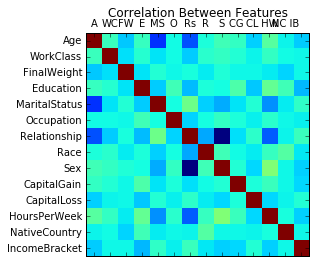

In [33]:
plt.matshow(eggs)
axis_label = ['Age','WorkClass','FinalWeight','Education','MaritalStatus','Occupation','Relationship','Race','Sex',
              'CapitalGain','CapitalLoss','HoursPerWeek','NativeCountry','IncomeBracket']
axis_label_x = ['A','WC','FW','E','MS','O','Rs','R','S',
              'CG ','CL ',' HW ','NC ''IB']
x_pos = np.arange(len(axis_label))
plt.xticks(x_pos,axis_label_x)
y_pos = np.arange(len(axis_label))
plt.yticks(y_pos,axis_label)
plt.title('Correlation Between Features')
plt.show()

The correlation matrix image above shows how each feature is related to each other and the income brackets. A red box shows that the matrix is positive 1 related and a dark blue/black means negative 1. From the above the most original attributes  that are related to the income bracket value respectively in order are Education, Relationship, Age, Sex, HoursPerWeek, MaritalStatus and CapitalGain. 

## 4.0 Feature Selection

For model training, not all features from the original have to be used. As seen in Section 3.2 not all attributes  are helpful because they do not really correlate to the income bracket. Therefore, any feature with correlation below 0.05 (absolute value) was not taken except Occupation. Occupation is the exception because a feature relating back to the sample's career may be useful for other datasets. As well it has higher correlation than WorkClass and hence why it is taken over that feature.  <br> This leaves the following features: <br>Education <br>Relationship <br>Age <br>Sex<br>HoursPerWeek<br>Occupation<br>MaritalStatus<br>CapitalGain<br><br> From this list the last two are dropped. This is because MaritalStatus and Relationship are similar therefore only one is needed to not create a bias and CapitalGain is used to create a new feature. The rest of the original features are dropped using the lines of code below. 

In [34]:
dataset_model = dataset_pca
dataset_model = dataset_model.drop('WorkClassLvl',1)
dataset_model = dataset_model.drop('FinalWeightLvl',1)
dataset_model = dataset_model.drop('MaritalStatusLvl',1)
dataset_model = dataset_model.drop('RaceLvl',1)
dataset_model = dataset_model.drop('CapitalGainLvl',1)
dataset_model = dataset_model.drop('CapitalLossLvl',1)
dataset_model = dataset_model.drop('NativeCountryLvl',1)
dataset_model.head()

,AgeLvl,EducationLvl,OccupationLvl,RelationshipLvl,SexLvl,HoursPerWeekLvl,IncomeBracketLvl
0,3,10,4,0,1,1,1
1,1,10,7,1,0,1,1
2,1,10,13,0,1,1,0
3,2,5,2,0,1,1,1
4,4,14,11,0,1,2,1


The new feature added to the dataset using the existing information is Investment Income. This is essentially the difference between the CapitalGain and CapitalLoss. The advantage of this is that now the full story can be seen on how the Capital affect what class the sample is in. This new feature creation is called feature engineering. It is a very useful tool because it can be used to create features that create a better covariance and even reduce the number of features, so the cost is less to run the algorithm. It can also be used to understand new aspects of the data. 

In [35]:
dataset['InvestmentIncome'] = dataset['CapitalGain'] - dataset['CapitalLoss']

In [36]:
dataset['InvestmentIncomeLvl'] = pd.cut(dataset['InvestmentIncome'], 
                                        bins=[0,10000,20000,30000,40000,50000,60000,70000,80000,90000,100000,np.inf],
                                        labels=[0,1,2,3,4,5,6,7,8,9,10])

In [37]:
dataset["InvestmentIncomeLvl"] = dataset["InvestmentIncomeLvl"].astype('int8')
dataset_model['InvestmentIncomeLvl'] = dataset["InvestmentIncomeLvl"]
dataset_model = dataset_model[['AgeLvl','EducationLvl','OccupationLvl','RelationshipLvl','SexLvl','InvestmentIncomeLvl',
                               'HoursPerWeekLvl','IncomeBracketLvl']]
dataset_model.head()

,AgeLvl,EducationLvl,OccupationLvl,RelationshipLvl,SexLvl,InvestmentIncomeLvl,HoursPerWeekLvl,IncomeBracketLvl
0,3,10,4,0,1,0,1,1
1,1,10,7,1,0,0,1,1
2,1,10,13,0,1,0,1,0
3,2,5,2,0,1,0,1,1
4,4,14,11,0,1,0,2,1


## 5.0 Model Implementation

The step below splits the dataset_model into the features and the response.

In [38]:
x = dataset_model[dataset_model.columns[0:6]]
y = dataset_model[dataset_model.columns[7]]

### 5.1 k-Nearest Neighbor Classifier (kNN)

This classifier uses the training samples to make the prediction. It basically uses the points closest to the sample in question to make a prediction. The number of samples it uses depends on the k-value. Once it knows its neighbors it sees which class is most dominant within the radius and then says okay the sample must be the dominant class. <br><br>Pro:<br>This is a very simple classifier and does not require a training phase. As well, it is robust to noisy data. <br><br>Con:<br> Need to determine proper k-value. If a low k-value is used, then there may be not enough comparison. If a high k-value is used, then unnecessary points are there. This means that neighbors that are nothing alike will be used and can mess up the prediction. Also, the computation-cost of this algorithm can be high. <br><br>Why?<br> I chose this algorithm because it is simple to use. It does not require a learning phase. Also for this dataset, where there are so many samples and features a classifier like this can be useful. 

In [39]:
knn = KNeighborsClassifier(n_neighbors=10)
scores_knn = cross_val_score(knn, x, y, cv=10, scoring='accuracy')
print(scores_knn)
print(scores_knn.mean())

[ 0.77415086  0.78022948  0.76831421  0.78464254  0.76566637  0.77184466
  0.7607064   0.76766784  0.77208481  0.77120141]
0.771650858944


The accuracy across the folds are very close with some areas having better results. This is probably due to the way the data is spread out in these folds. As well the kNN does not have a learning phase so it is dependent on the fold more.

### 5.2 Logistic Regression

Logistic Regression is similar to linear regression because It uses a line of best fit to make predictions. But instead it uses a non-linear function and takes the form of the sigmoid function. With this function and a decision boundary it can classify new data points and make predictions similar to linear regression.<br><br>Pro:<br> The advantages of this classifier is that this classifier is prone to less over-fitting and can be really fast. As well it can be updated easily. <br><br>Con:<br> The disadvantages are that it works best for a single decision boundary and not ideal for complex cases. <br><br>Why?<br> I used this classifier because of its speed and the fact that it is less likely to over-fit. Which for a dataset and number of features like this it is possible. As well, to see how it performs if it has to classify between three classes and if there is a drop off compared to the rest. 

In [40]:
lr = LogisticRegression()
scores_lr = cross_val_score(lr, x, y, cv=10, scoring='accuracy')
print(scores_lr)
print(scores_lr.mean())

[ 0.77018086  0.76478376  0.77096205  0.7674316   0.77537511  0.77405119
  0.76379691  0.7725265   0.77385159  0.78224382]
0.771520338035


This classifier has a more consistent accuracy across each fold and it is because this classifier uses a 'line' of best method which will be very similar for each fold.

### 5.3 Random Forest Classifier

This classifier uses decision trees to make predictions. Essentially it creates a bunch of trees which try to expand as much as they are allowed too. Then each tree places a vote on which class the sample in question is. After that it makes its decision based on the highest vote. <br><br>Pro: The advantages to this classifier are that it will not overfit the model and that it can handle large datasets with high dimensionality. It can also handle missing values and still maintain its accuracy. <br><br>Con:<br>This classifier can not be controlled on what it does and thus that is disadvantage. <br><br>Why?<br> Random Forest Classifier was used because the dataset is large and there are many features. Also, it is excellent for classification and it will not overfit the model.  

In [41]:
rfc = RandomForestClassifier()
scores_rfc = cross_val_score(rfc, x, y, cv=10, scoring='accuracy')
print(scores_rfc)
print(scores_rfc.mean())

[ 0.77679753  0.78067079  0.78022948  0.78464254  0.77978817  0.78729038
  0.77350993  0.7844523   0.77915194  0.78268551]
0.780921857542


This classifier has a more consistent accuracy accross each fold and it is because this classifier will have the same trees with just very slight changes in probability.

### 5.4 Gradient Boosting Classifier

This classifier uses decision trees to make predictions. However, instead of fully growing the tree it creates stump like trees. It bases the trees on weak learners and aims to lower biases. <br><br>Pro: The advantages to this classifier are that it will not underfit the model. <br> <br>Con:<br> The disadvantages are that it takes long time to compute and it is prone to overfitting. <br><br>Why?<br> I used this classifier because it is the opposite of Random Forest in how it works, and it will decrease the bias of some of the features. As well, in some cases this has performed better than Random Forest as stated by other sources.

In [42]:
gbc = GradientBoostingClassifier()
scores_gbc = cross_val_score(gbc, x, y, cv=10, scoring='accuracy')
print(scores_gbc)
print(scores_gbc.mean())

[ 0.79003088  0.79655781  0.79214475  0.79655781  0.79390997  0.7961165
  0.78013245  0.79019435  0.795053    0.79461131]
0.792530883446


This classifier has a more consistent accuracy across each fold and it is because this classifier will have the same trees with just very slight changes in probability.

## 6.0 Model Tuning

### 6.1 Grid Search

#### 6.1.1 k-Nearest Neighbor Classifier (kNN)

The parameters chosen for grid search for kNN are the k-value and weight options. K-value is used because it relates how many neighbours to find and weight is how the neighbours are found. 

In [43]:
k_range = list(range(1, 21))
weight_options = ['uniform', 'distance']
param_grid = dict(n_neighbors=k_range, weights=weight_options)
print(param_grid)
grid_knn = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')
grid_knn.fit(x, y)
print(grid_knn.best_score_)
print(grid_knn.best_params_)

{'weights': ['uniform', 'distance'], 'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]}
0.7803919837556281
{'weights': 'uniform', 'n_neighbors': 18}


In [44]:
grid_knn.grid_scores_

[mean: 0.71811, std: 0.00992, params: {'weights': 'uniform', 'n_neighbors': 1},
 mean: 0.71811, std: 0.00992, params: {'weights': 'distance', 'n_neighbors': 1},
 mean: 0.71462, std: 0.00911, params: {'weights': 'uniform', 'n_neighbors': 2},
 mean: 0.71511, std: 0.00923, params: {'weights': 'distance', 'n_neighbors': 2},
 mean: 0.75060, std: 0.00498, params: {'weights': 'uniform', 'n_neighbors': 3},
 mean: 0.74715, std: 0.00530, params: {'weights': 'distance', 'n_neighbors': 3},
 mean: 0.74777, std: 0.00411, params: {'weights': 'uniform', 'n_neighbors': 4},
 mean: 0.74464, std: 0.00501, params: {'weights': 'distance', 'n_neighbors': 4},
 mean: 0.76282, std: 0.00601, params: {'weights': 'uniform', 'n_neighbors': 5},
 mean: 0.75806, std: 0.00522, params: {'weights': 'distance', 'n_neighbors': 5},
 mean: 0.76574, std: 0.00457, params: {'weights': 'uniform', 'n_neighbors': 6},
 mean: 0.76115, std: 0.00454, params: {'weights': 'distance', 'n_neighbors': 6},
 mean: 0.76746, std: 0.00604, para

#### 6.1.2 Logistic Regression

The parameters chosen for grid search for Logistic Regression is the solver option because some solvers may produce better results and are better for certain types of data. 

In [45]:
solver_options = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
param_grid = dict(solver=solver_options)
print(param_grid)
grid_lr = GridSearchCV(lr, param_grid, cv=10, scoring='accuracy')
grid_lr.fit(x, y)
print(grid_lr.best_score_)
print(grid_lr.best_params_)

{'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}


/usr/local/lib/python3.5/dist-packages/scipy/optimize/linesearch.py:285: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


0.7720490862540832
{'solver': 'newton-cg'}


In [46]:
grid_lr.grid_scores_

[mean: 0.77205, std: 0.00447, params: {'solver': 'newton-cg'},
 mean: 0.77205, std: 0.00447, params: {'solver': 'lbfgs'},
 mean: 0.77152, std: 0.00516, params: {'solver': 'liblinear'},
 mean: 0.77205, std: 0.00447, params: {'solver': 'sag'},
 mean: 0.77205, std: 0.00447, params: {'solver': 'saga'}]

#### 6.1.3 Random Forest Classifier

The parameters chosen for grid search for random forest classifier are the max depth and n_estimator. Max depth controls how large the tree is allowed to grow and n_estimator is the number of trees allowed. 

In [47]:
max_depth_range = list(range(1,31))
n_est_range = list(range(10,12))
param_grid = dict(max_depth = max_depth_range, n_estimators = n_est_range)
print(param_grid)
grid_rfc = GridSearchCV(rfc, param_grid, cv=10, scoring='accuracy')
grid_rfc.fit(x, y)
print(grid_rfc.best_score_)
print(grid_rfc.best_params_)

{'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30], 'n_estimators': [10, 11]}
0.7898825814425708
{'max_depth': 8, 'n_estimators': 11}


In [48]:
grid_rfc.grid_scores_

[mean: 0.74834, std: 0.00472, params: {'max_depth': 1, 'n_estimators': 10},
 mean: 0.74605, std: 0.00029, params: {'max_depth': 1, 'n_estimators': 11},
 mean: 0.75903, std: 0.00882, params: {'max_depth': 2, 'n_estimators': 10},
 mean: 0.75956, std: 0.00892, params: {'max_depth': 2, 'n_estimators': 11},
 mean: 0.76953, std: 0.01198, params: {'max_depth': 3, 'n_estimators': 10},
 mean: 0.77704, std: 0.00691, params: {'max_depth': 3, 'n_estimators': 11},
 mean: 0.78251, std: 0.00435, params: {'max_depth': 4, 'n_estimators': 10},
 mean: 0.78264, std: 0.00553, params: {'max_depth': 4, 'n_estimators': 11},
 mean: 0.78662, std: 0.00432, params: {'max_depth': 5, 'n_estimators': 10},
 mean: 0.78745, std: 0.00504, params: {'max_depth': 5, 'n_estimators': 11},
 mean: 0.78882, std: 0.00372, params: {'max_depth': 6, 'n_estimators': 10},
 mean: 0.78816, std: 0.00546, params: {'max_depth': 6, 'n_estimators': 11},
 mean: 0.78949, std: 0.00488, params: {'max_depth': 7, 'n_estimators': 10},
 mean: 0.788

#### 6.1.4 Gradient Boosting Classifier

The parameters chosen for grid search for gradient boosting classifier are the max depth and n_estimator. Max depth controls how large the tree is allowed to grow and n_estimator is the number of trees allowed. 

In [49]:
max_depth_range = list(range(1,3))
n_est_range = list(range(100,104))
param_grid = dict(max_depth = max_depth_range, n_estimators = n_est_range)
print(param_grid)
grid_gbc = GridSearchCV(gbc, param_grid, cv=10, scoring='accuracy')
grid_gbc.fit(x, y)
print(grid_gbc.best_score_)
print(grid_gbc.best_params_)

{'max_depth': [1, 2], 'n_estimators': [100, 101, 102, 103]}
0.7908978546834996
{'max_depth': 2, 'n_estimators': 102}


In [50]:
grid_gbc.grid_scores_

[mean: 0.78697, std: 0.00408, params: {'max_depth': 1, 'n_estimators': 100},
 mean: 0.78697, std: 0.00408, params: {'max_depth': 1, 'n_estimators': 101},
 mean: 0.78693, std: 0.00404, params: {'max_depth': 1, 'n_estimators': 102},
 mean: 0.78693, std: 0.00404, params: {'max_depth': 1, 'n_estimators': 103},
 mean: 0.79072, std: 0.00474, params: {'max_depth': 2, 'n_estimators': 100},
 mean: 0.79072, std: 0.00474, params: {'max_depth': 2, 'n_estimators': 101},
 mean: 0.79090, std: 0.00474, params: {'max_depth': 2, 'n_estimators': 102},
 mean: 0.79077, std: 0.00451, params: {'max_depth': 2, 'n_estimators': 103}]

### 6.2 Confusion Matrix

Using the optimal parameters found. A confusion matrix was used to find the true positive rate and false positive rate. 

#### 6.2.1 k-Nearest Neighbor Classifier (kNN)

In [51]:
knn = KNeighborsClassifier(n_neighbors=18,weights='uniform')
knn.fit(x, y)
knn_pred = knn.predict(x)
confusion_knn = metrics.confusion_matrix(y, knn_pred)
confusion_knn

array([[ 1752,  2038,    47],
       [  871, 15987,    43],
       [  768,  1071,    77]])

#### 6.2.2 Logistic Regression

In [52]:
lr = LogisticRegression(solver='newton-cg')
lr.fit(x, y)
lr_pred = lr.predict(x)
confusion_lr = metrics.confusion_matrix(y, lr_pred)
confusion_lr

array([[ 1049,  2788,     0],
       [  471, 16430,     0],
       [  519,  1397,     0]])

#### 6.2.3 Random Forest Classifier

In [53]:
rfc = RandomForestClassifier(n_estimators=11,max_depth=7)
rfc.fit(x, y)
rfc_pred = rfc.predict(x)
confusion_rfc = metrics.confusion_matrix(y, rfc_pred)
confusion_rfc

array([[ 1630,  2204,     3],
       [  606, 16295,     0],
       [  771,  1114,    31]])

#### 6.2.4 Gradient Boosting Classifier

In [54]:
gbc = GradientBoostingClassifier(n_estimators=102,max_depth=2)
gbc.fit(x, y)
gbc_pred = gbc.predict(x)
confusion_gbc = metrics.confusion_matrix(y, gbc_pred)
confusion_gbc

array([[ 1766,  2069,     2],
       [  730, 16170,     1],
       [  882,  1028,     6]])

### 6.3 Optimal Model

The optimal model is the Random Forest Classifier. It has the second highest accuracy calculated from the k-fold cross validation and grid search. However, the grid search is just slightly below the most accurate classifier which is the Gradient Boosting Classifier. On the other hand, Random Forest Classifier has a higher true positive for less than 50k class and greater than 100k class when compared to Gradient Boosting Classifier. Therefore, it is the optimal model.<br> <br> Grid search accuracy and confusion matrix were used because they can show the whole picture together. Grid search shows how well the model is accurate between 10-folds of the data and which parameters are optimal. This covers the fact that the model behaves well with the data. However, the confusion matrix shows how much of each class did the classifier get right thus allowing for a deeper look at accuracy. This is ideal because the optimal model should predict more classes correctly at higher rate and not just the overall dataset. Then this measure can be compared with the accuracy to see the trade-off between each of the four models. Thus, as stated above the Random Forest Classifier was chosen because it performed consistently better even within the deeper analysis. 

## 7.0 Testing

### 7.1 Import and Clean Test Data

_Note that for the file to be read it must be present within the workbench with the exact same name._

In [55]:
dataset_test = pd.read_csv('income-testing.csv')

In [56]:
dataset_test = dataset_test.dropna(subset=["Occupation","WorkClass"],thresh=1)
dataset_test = dataset_test.dropna(subset=["MaritalStatus","Relationship"],thresh=1)
dataset_test = dataset_test.dropna(subset=["Education","EducationLvl"],thresh=1)
dataset_test = dataset_test.dropna(subset=["Age"])
dataset_test = dataset_test.dropna(subset=["FinalWeight"])
dataset_test = dataset_test.dropna(subset=["Race"])
dataset_test = dataset_test.dropna(subset=["Sex"])
dataset_test = dataset_test.dropna(subset=["CapitalGain"])
dataset_test = dataset_test.dropna(subset=["CapitalLoss"])
dataset_test = dataset_test.dropna(subset=["HoursPerWeek"])
dataset_test = dataset_test.dropna(subset=["NativeCountry"])
dataset_test = dataset_test.dropna(subset=["IncomeBracket"])
dataset_test = dataset_test.dropna(subset=["Occupation"])
dataset_test = dataset_test.dropna(subset=["WorkClass"])
dataset_test = dataset_test.dropna(subset=["MaritalStatus"])
dataset_test = dataset_test.dropna(subset=["Relationship"])
dataset_test = dataset_test.dropna(subset=["Education"])
dataset_test = dataset_test.dropna(subset=["EducationLvl"])

In [57]:
dataset_test["WorkClass"] = dataset_test["WorkClass"].astype('category')
dataset_test["WorkClassLvl"] = dataset_test["WorkClass"].astype('category').cat.codes
dataset_test["MaritalStatus"] = dataset_test["MaritalStatus"].astype('category')
dataset_test["MaritalStatusLvl"] = dataset_test["MaritalStatus"].astype('category').cat.codes
dataset_test["Occupation"] = dataset_test["Occupation"].astype('category')
dataset_test["OccupationLvl"] = dataset_test["Occupation"].astype('category').cat.codes
dataset_test["Relationship"] = dataset_test["Relationship"].astype('category')
dataset_test["RelationshipLvl"] = dataset_test["Relationship"].astype('category').cat.codes
dataset_test["Race"] = dataset_test["Race"].astype('category')
dataset_test["RaceLvl"] = dataset_test["Race"].astype('category').cat.codes
dataset_test["Sex"] = dataset_test["Sex"].astype('category')
dataset_test["SexLvl"] = dataset_test["Sex"].astype('category').cat.codes
dataset_test["NativeCountry"] = dataset_test["NativeCountry"].astype('category')
dataset_test["NativeCountryLvl"] = dataset_test["NativeCountry"].astype('category').cat.codes
dataset_test["IncomeBracketLvl"] = dataset_test["IncomeBracket"].astype('category').cat.codes

In [58]:
dataset_test['AgeLvl'] = pd.cut(dataset_test['Age'], bins=[17,23,29,39,49,64,np.inf], labels=[0,1,2,3,4,5])
dataset_test['HoursPerWeekLvl'] = pd.cut(dataset_test['HoursPerWeek'], bins=[0,20,40,60,80,np.inf], labels=[0,1,2,3,4])
dataset_test['FinalWeightLvl'] = pd.cut(dataset_test['FinalWeight'], 
                                        bins=[0,150000,300000,450000,600000,1000000,np.inf], labels=[0,1,2,3,4,5])

In [59]:
dataset_test["AgeLvl"] = dataset_test["AgeLvl"].astype('int8')
dataset_test["HoursPerWeekLvl"] = dataset_test["HoursPerWeekLvl"].astype('int8')
dataset_test["FinalWeightLvl"] = dataset_test["FinalWeightLvl"].astype('int8')
dataset_test['CapitalGainLvl'] = pd.cut(dataset_test['CapitalGain'], 
                                        bins=[0,10000,20000,30000,40000,50000,60000,70000,80000,90000,100000,np.inf],
                                        labels=[0,1,2,3,4,5,6,7,8,9,10])
dataset_test["CapitalGainLvl"] = dataset_test["CapitalGainLvl"].astype('int8')
dataset_test['CapitalLossLvl'] = pd.cut(dataset_test['CapitalLoss'], 
                                        bins=[-np.inf,-100000,-90000,-80000,-70000,-60000,-50000,-40000,-30000,-20000,-10000,0],
                                        labels=[0,1,2,3,4,5,6,7,8,9,10])
dataset_test["CapitalLossLvl"] = dataset_test["CapitalLossLvl"].astype('int8')

In [60]:
dataset_test.dtypes

Age                    int64
WorkClass           category
FinalWeight            int64
Education             object
EducationLvl           int64
MaritalStatus       category
Occupation          category
Relationship        category
Race                category
Sex                 category
CapitalGain            int64
CapitalLoss            int64
HoursPerWeek           int64
NativeCountry       category
IncomeBracket         object
WorkClassLvl            int8
MaritalStatusLvl        int8
OccupationLvl           int8
RelationshipLvl         int8
RaceLvl                 int8
SexLvl                  int8
NativeCountryLvl        int8
IncomeBracketLvl        int8
AgeLvl                  int8
HoursPerWeekLvl         int8
FinalWeightLvl          int8
CapitalGainLvl          int8
CapitalLossLvl          int8
dtype: object

In [61]:
dataset_model_test = dataset_test[['AgeLvl','WorkClassLvl','FinalWeightLvl','EducationLvl','MaritalStatusLvl','OccupationLvl',
                                   'RelationshipLvl','RaceLvl','SexLvl','CapitalGainLvl','CapitalLossLvl','HoursPerWeekLvl',
                                   'NativeCountryLvl','IncomeBracketLvl']]

In [62]:
dataset_model_test = dataset_model_test.drop('WorkClassLvl',1)
dataset_model_test = dataset_model_test.drop('FinalWeightLvl',1)
dataset_model_test = dataset_model_test.drop('MaritalStatusLvl',1)
dataset_model_test = dataset_model_test.drop('RaceLvl',1)
dataset_model_test = dataset_model_test.drop('CapitalGainLvl',1)
dataset_model_test = dataset_model_test.drop('CapitalLossLvl',1)
dataset_model_test = dataset_model_test.drop('NativeCountryLvl',1)

In [63]:
dataset_test['InvestmentIncome'] = dataset_test['CapitalGain'] - dataset['CapitalLoss']
dataset_test['InvestmentIncomeLvl'] = pd.cut(dataset_test['InvestmentIncome'], 
                                             bins=[0,10000,20000,30000,40000,50000,60000,70000,80000,90000,100000,np.inf],
                                             labels=[0,1,2,3,4,5,6,7,8,9,10])
dataset_test["InvestmentIncomeLvl"] = dataset_test["InvestmentIncomeLvl"].astype('int8')
dataset_model_test['InvestmentIncomeLvl'] = dataset_test["InvestmentIncomeLvl"]
dataset_model_test = dataset_model_test[['AgeLvl','EducationLvl','OccupationLvl','RelationshipLvl','SexLvl',
                                         'InvestmentIncomeLvl', 'HoursPerWeekLvl','IncomeBracketLvl']]
dataset_model_test.head()

,AgeLvl,EducationLvl,OccupationLvl,RelationshipLvl,SexLvl,InvestmentIncomeLvl,HoursPerWeekLvl,IncomeBracketLvl
0,4,10,11,5,0,0,1,0
1,2,13,7,2,1,0,2,1
2,1,13,7,1,0,0,1,1
3,1,13,13,2,1,0,1,1
4,0,9,7,2,0,0,1,1


### 7.2 Optimal Model Implementation

In [64]:
x_test = dataset_model_test[dataset_model_test.columns[0:6]]
y_test = dataset_model_test[dataset_model_test.columns[7]]

In [65]:
predicted = rfc.predict(x_test)
predicted

array([1, 1, 1, ..., 1, 1, 1], dtype=int8)

In [66]:
metrics.accuracy_score(y_test, predicted)

0.77704077120367909

In [67]:
metrics.confusion_matrix(y_test, predicted)

array([[ 755, 1124,   19],
       [ 345, 8021,    2],
       [ 397,  634,   10]])

### 7.3 Conclusion

Question: How does model perform vs tested? <br>

The model performs almost exactly like the training set. The accuracy is about 1.2% below (77.7% vs0.78.9%) the training set but the confusion matrix is very similar. It manages to predict the less than 50k class very well but suffers in the other two classes. This is what happened with the training set as well (training set confusion matrix shown below). The only difference is that the last income bracket class has more false positive results and hence struggles to perform well with this class in respect to the training set's performance. Nevertheless, the test shows that the model is trained properly and sufficient for use. 

In [68]:
confusion_rfc

array([[ 1630,  2204,     3],
       [  606, 16295,     0],
       [  771,  1114,    31]])